# Reinforcement Learning

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -U tf-agents pyvirtualdisplay
    %pip install -U gym>=0.21.0
    %pip install -U gym[box2d,atari,accept-rom-license]

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

No GPU was detected. CNNs can be very slow without a GPU.


## Introduction to OpenAI gym

OpenAI gym is a great toolkit for developing and comparing RL algorithms.

In [3]:
import gym


In [4]:
gym.envs.registry.all()


ValuesView(├──CartPole: [ v0, v1 ]
├──MountainCar: [ v0 ]
├──MountainCarContinuous: [ v0 ]
├──Pendulum: [ v1 ]
├──Acrobot: [ v1 ]
├──LunarLander: [ v2 ]
├──LunarLanderContinuous: [ v2 ]
├──BipedalWalker: [ v3 ]
├──BipedalWalkerHardcore: [ v3 ]
├──CarRacing: [ v1 ]
├──Blackjack: [ v1 ]
├──FrozenLake: [ v1 ]
├──FrozenLake8x8: [ v1 ]
├──CliffWalking: [ v0 ]
├──Taxi: [ v3 ]
├──Reacher: [ v2 ]
├──Pusher: [ v2 ]
├──InvertedPendulum: [ v2 ]
├──InvertedDoublePendulum: [ v2 ]
├──HalfCheetah: [ v2, v3 ]
├──Hopper: [ v2, v3 ]
├──Swimmer: [ v2, v3 ]
├──Walker2d: [ v2, v3 ]
├──Ant: [ v2, v3 ]
├──Humanoid: [ v2, v3 ]
└──HumanoidStandup: [ v2 ]
)

The Cart-Pole is a very simple environment composed of a cart that can move left and right, and the pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [5]:
env = gym.make("CartPole-v1")

env.reset(seed=42)
obs = env.reset()
print(obs)


[-0.04058227  0.04756223  0.02611397  0.02860643]


In [6]:
try:
    import pyvirtualdisplay

    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
    print(display)
except ImportError:
    pass


In [7]:
env.render()


True

In [8]:
img = env.render(mode="rgb_array")
print(img.shape)


(400, 600, 3)


In [9]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img


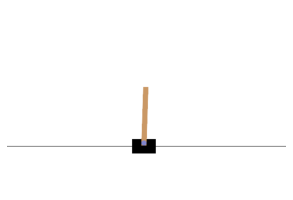

In [92]:
plot_environment(env)
plt.show()


In [93]:
print(env.action_space)


Discrete(2)


In [94]:
action = 1  # Accelerate towards right!
obs, reward, done, info = env.step(action)
print(obs)


[-0.03963102  0.24230015  0.0266861  -0.25572422]


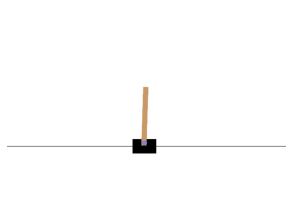

In [95]:
plot_environment(env)
plt.show()


In [96]:
print("Reward: {}".format(reward))
print("Done: {}".format(done))
print("Info: {}".format(info))


Reward: 1.0
Done: False
Info: {}


In [97]:
if done:
	obs = env.reset()

## A Simple Hard-coded Policy

This is a hard-coded simple strategy: If the pole is tilting to the left, then push the cart to the left, and vice versa

In [98]:
env.seed(42)


def basic_policy(obs):
    angle = obs[2]
    # Move left when angle < 0 and move right otherwise
    return 0 if angle < 0 else 1


totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)


/home/zuo/.local/lib/python3.10/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


In [99]:
print("Reward Mean: {}".format(np.mean(totals)))
print("Reward Std: {}".format(np.std(totals)))
print("Reward Min: {}".format(np.min(totals)))
print("Reward Max: {}".format(np.max(totals)))

print("Episodes: {}".format(len(totals)))

Reward Mean: 42.212
Reward Std: 9.032998173364147
Reward Min: 24.0
Reward Max: 72.0
Episodes: 500


Use matplotlib animation to visualize one episode using a batch of frames...

In [100]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)  # Just get the frame in RGB
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break


In [10]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return (patch,)


def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis("off")
    anim = animation.FuncAnimation(
        fig,
        update_scene,
        fargs=(frames, patch),
        frames=len(frames),
        repeat=repeat,
        interval=interval,
    )
    plt.close()
    return anim


In [102]:
plot_animation(frames)

In [103]:
env.close()

## Neural Network Policies

Create a neural network that will take observations as inputs, and output the probability of actions to take for each observation.
The network will estimate a probability for each action, then we'll select an action randomly according to the estimated probabilities.
For the Cart-Pole environment, there are just two possible actions, so a single neuron is needed!

In [104]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4

model = keras.models.Sequential(
    [
        keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
        # Just one output for left, right
		keras.layers.Dense(1, activation="sigmoid"),
    ]
)


In this particular environment, each observation contains the environment's full state.


In [105]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []

    env = gym.make("CartPole-v1")
    env.reset(seed=seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames


In [106]:
frames = render_policy_net(model)
plot_animation(frames)


In [107]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.0] if obs[2] < 0 else [0.0]) for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()


/home/zuo/.local/lib/python3.10/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


Iteration: 4999, Loss: 0.052

In [108]:
frames = render_policy_net(model)
plot_animation(frames)


## Policy Gradients

The policy gradients algorithm tackles this problem by firstly playing multiple episodes, then making the actions in good episodes slightly more likely, while actions in bad episodes are made slightly less likely.

In [124]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = tf.random.uniform([1, 1]) > left_proba
        # So it assume the action takes is the right action! Left -> 0, Right -> 1.
        y_target = tf.constant([[1.0]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads


In [125]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads


In [126]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted


def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [
        discount_rewards(rewards, discount_rate) for rewards in all_rewards
    ]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [
        (discounted_rewards - reward_mean) / reward_std
        for discounted_rewards in all_discounted_rewards
    ]


In [127]:
discount_rewards([10, 0, -50], discount_rate=0.8)


array([-22, -40, -50])

In [128]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)


[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [140]:
n_iterations = 100
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95


In [141]:

optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy


In [142]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential(
    [
        keras.layers.Dense(5, activation="elu", input_shape=[4]),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)


In [143]:
env = gym.make("CartPole-v1")
env.seed(42)

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn
    )
    total_rewards = sum(map(sum, all_rewards))
    print(
        "\rIteration: {}, mean rewards: {:.1f}".format(
            iteration, total_rewards / n_episodes_per_update
        ),
        end="",
    )
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [
                final_reward * all_grads[episode_index][step][var_index]
                for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)
            ],
            axis=0,
        )
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()


/home/zuo/.local/lib/python3.10/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


Iteration: 99, mean rewards: 186.2

In [144]:
frames = render_policy_net(model)

plot_animation(frames)


## Markov Chains

In [145]:
np.random.seed(42)

transition_probabilities = [  # shape=[s, s']
    [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
    [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
    [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
    [0.0, 0.0, 0.0, 1.0],
]  # from s3 to ...

n_max_steps = 50


def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(
            range(4), p=transition_probabilities[current_state]
        )
    else:
        print("...", end="")
    print()


for _ in range(10):
    print_sequence()


States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


## Q-Value Iteration

In [166]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None],
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]],
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

print(Q_values)

[[  0.   0.   0.]
 [  0. -inf   0.]
 [-inf   0. -inf]]


In [167]:
gamma = 0.90  # the discount factor

history1 = []  # Not shown in the book (for the figure below)
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)  # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum(
                [
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                    for sp in range(3)
                ]
            )

history1 = np.array(history1)  # Not shown


In [175]:
print("The optimal action of each state:")
print(np.argmax(Q_values, axis=1))


The optimal action of each state:
[0 0 1]


## Q-Learning

Q-learning works by watching an agent play and gradually improving its estimate of the Q-values.
Once it has accurate Q-value estimates, then the optimal policy consists in choosing the action that has the highest Q-value (i.e. greedy policy).

In [170]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward


In [171]:
# Just randomly visit all possible next states
def exploration_policy(state):
    return np.random.choice(possible_actions[state])


In [172]:
np.random.seed(42)

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05
decay = 0.005
gamma = 0.90  # discount factor
state = 0  # initial stat
history2 = []

for iteration in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])  # Use greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)


In [173]:
print(Q_values)
print("Optimal action for each state:")
print(np.argmax(Q_values, axis=1))


[[18.77621289 17.2238872  13.74543343]
 [ 0.                -inf -8.00485647]
 [       -inf 49.40208921        -inf]]
Optimal action for each state:
[0 0 1]


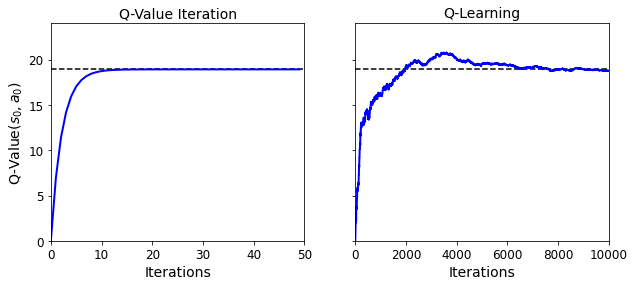

In [176]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])


plt.show()


## Deep Q-Network

Q-learning works by watching an agent play randomly and gradually improving its estimates of the Q-values.
For Deep Q-Network: Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expected after it plays that action.

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model = keras.models.Sequential(
    [
        keras.layers.Dense(32, activation="elu", input_shape=input_shape),
        keras.layers.Dense(32, activation="elu"),
        keras.layers.Dense(n_outputs),
    ]
)


In [13]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        # Exploring
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        # Exploiting the best Q-value
        return np.argmax(Q_values[0])


In [14]:
from collections import deque

replay_memory = deque(maxlen=2000)


In [15]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones


In [16]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info


In [17]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error


def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = rewards + (1 - dones) * discount_rate * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


In [18]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0


In [27]:
for episode in range(500):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)  # Not shown in the book
    if step >= best_score:  # Not shown
        best_weights = model.get_weights()  # Not shown
        best_score = step  # Not shown
    print(
        "\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon),
        end="",
    )  # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)


Episode: 49, Steps: 29, eps: 0.902

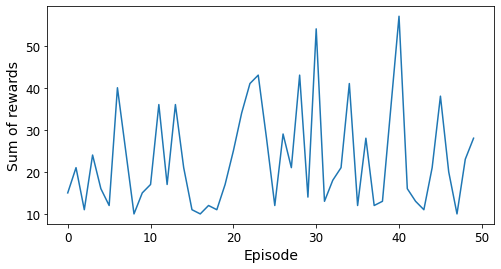

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)

plt.show()


In [29]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

plot_animation(frames)


/home/zuo/.local/lib/python3.10/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
